In [1]:
from keras import applications
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils.np_utils import to_categorical 
from keras.callbacks import ModelCheckpoint
from keras import Model
from keras import initializers
from keras.callbacks import LearningRateScheduler
from keras.utils import layer_utils, np_utils
from keras.applications.xception import preprocess_input
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils import class_weight
import seaborn as sn
from scipy import interp
from itertools import cycle
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

Using TensorFlow backend.
c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
image_width = 224
image_height = 224

# Change the batchsize according to your system RAM
batch_size = 64

train_dir = "D:/retinal_data_set_visioncare/VISION_CARE/"

xception_base = applications.Xception(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))

In [3]:
flatten = Flatten()
feature_extraction_layer = flatten(xception_base.get_layer(index=-1).output)
model = Model(inputs=xception_base.input, outputs=feature_extraction_layer)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [4]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_width, image_height),
        batch_size=batch_size,
        class_mode=None,  # this means our generator will only yield batches of data, no labels
        shuffle=False)

nb_train_samples = len(train_generator.filenames)  
num_classes = len(train_generator.class_indices)

# get the class lebels for the training data, in the original order  
train_labels = train_generator.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 183 images belonging to 5 classes.


In [5]:
# the predict_generator method returns the output of a model, given
# a generator that yields batches of numpy data
bottleneck_features_train = model.predict_generator(train_generator, nb_train_samples // batch_size + 1)
# save the output as a Numpy array
np.save(open('C:/Users/hp/Desktop/Diabetic_retinopathy_dataset_kaggle/models/xception/bottle_neck_features/bottleneck_features_train_visioncare_without_gap_svd.npy', 'wb'), bottleneck_features_train)

In [6]:
train_data = np.load(open('C:/Users/hp/Desktop/Diabetic_retinopathy_dataset_kaggle/models/xception/bottle_neck_features/bottleneck_features_train_visioncare_without_gap_svd.npy', 'rb'))
#test_data = np.load(open('D:/retinal_data_set_visioncare/models/xception/bottle_neck_features/bottleneck_features_test_without_aug.npy', 'rb'))

In [7]:
train_data_labels = train_generator.classes

In [8]:
# Feature Scaling - fature normalizing
scaler = StandardScaler()
X_train = scaler.fit_transform(train_data)

In [9]:
len(X_train)

183

In [10]:
train_data_labels = train_generator.classes  

X = X_train
Y = train_data_labels

In [11]:
len(Y)

183

In [12]:
np.unique(train_data_labels)

array([0, 1, 2, 3, 4])

In [13]:
class_weight = class_weight.compute_class_weight('balanced'
                                               ,np.unique(train_data_labels)
                                               ,train_data_labels)

In [14]:
dict(enumerate(class_weight))

{0: 0.9384615384615385,
 1: 1.6636363636363636,
 2: 0.4945945945945946,
 3: 1.83,
 4: 1.3071428571428572}

In [15]:
class_weight_dic = dict(enumerate(class_weight))

In [16]:
# define 5-fold cross validation test harness
#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=25)
cvscores = []
trainScores = []
f1Score = []
num_k_folds = 5
fold_counter = 0
val_conmats = []
val_precisions = []
val_recalls = []
val_f_scores = []
input_dim = X_train.shape[1:][0]

cross_model = Sequential()
cross_model.add(Dense(128, input_dim=input_dim, kernel_initializer=initializers.he_normal(seed=None), kernel_regularizer=regularizers.l2(0.001)))
cross_model.add(BatchNormalization())
cross_model.add(Activation('relu'))
cross_model.add(Dropout(0.8))
cross_model.add(Dense(5, kernel_initializer=initializers.he_normal(seed=None), kernel_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l2(0.001)))
cross_model.add(BatchNormalization())
cross_model.add(Activation('softmax'))

cross_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [17]:
for train, test in kfold.split(X, Y):
    # Fit the model
    cross_model.fit(X[train], to_categorical(Y[train]), epochs=400, batch_size=batch_size, class_weight=class_weight_dic, verbose=0)
    
    y_train_pred = cross_model.predict(X[train])
    y_train_pred = np.argmax(y_train_pred, axis=1)
    
    y_validation_pred = cross_model.predict(X[test])
    y_validation_pred = np.argmax(y_validation_pred, axis=1)
    #y_validation_pred = np.argmax(y_validation_pred, axis=1)
    
    [precision, recall, f_score, _] = precision_recall_fscore_support(Y[test], y_validation_pred)
    #print("Validation k-fold #%d - precision: %f, recallL: %f, f-score: %f" % (fold_counter, precision, recall, f_score))
    
    conmat = confusion_matrix(Y[test], y_validation_pred)
    
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f_scores.append(f_score)
    val_conmats.append(conmat)
    fold_counter = fold_counter + 1
    
    trainScores.append(accuracy_score(Y[train], y_train_pred))
    cvscores.append(accuracy_score(Y[test], y_validation_pred))
    
print("\nAveraging the 5-fold results:")
print("%s: %.2f%%" % ('AVG Train Acc ', np.mean(trainScores) * 100))
print("%s: %.2f%%" % ('AVG Validation Acc ', np.mean(cvscores) * 100))
print("Validation precision - mean: %f, stddev: %f" % (np.mean(val_precisions), np.std(val_precisions)))
print("Validation recall - mean: %f, stddev: %f" % (np.mean(val_recalls), np.std(val_recalls)))
print("Validation f-score - mean: %f, stddev: %f" % (np.mean(val_f_scores), np.std(val_f_scores)))
print("Confusion matrix:")
print (sum(val_conmats).astype(float) / fold_counter)


Averaging the 5-fold results:
AVG Train Acc : 100.00%
AVG Validation Acc : 84.62%
Validation precision - mean: 0.859218, stddev: 0.165409
Validation recall - mean: 0.813638, stddev: 0.207031
Validation f-score - mean: 0.822365, stddev: 0.169986
Confusion matrix:
[[ 6.56  0.36  0.72  0.    0.16]
 [ 0.92  2.64  0.76  0.    0.08]
 [ 0.68  0.4  13.6   0.    0.12]
 [ 0.    0.    0.48  3.4   0.12]
 [ 0.    0.12  0.44  0.32  4.72]]


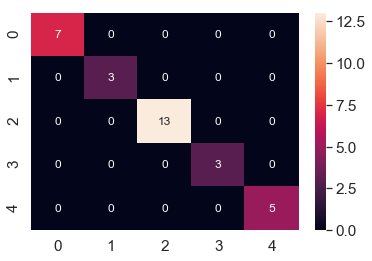

In [18]:
confusion_matrix_array = (sum(val_conmats).astype(float) / fold_counter)
new_confusion_matrix_array = []
for conf_sub_array in confusion_matrix_array:
    new_confusion_matrix_array.append([int(float(e)) for e in conf_sub_array])
        
df_cm = pd.DataFrame(new_confusion_matrix_array, range(5), range(5))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12})# font size